In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
# def application_train_test(num_rows = None, nan_as_category = False):
  df = pd.read_csv('/content/drive/My Drive/Database project/new_application_train.csv')
  print("Train samples: {}".format(df.shape))
  df = df.drop(['CODE_GENDER'], axis=1)
# Categorical features with Binary encode (0 or 1; two categories)
  for bin_feature in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
      df[bin_feature], uniques = pd.factorize(df[bin_feature])
# Categorical features with One-Hot encode
  df, cat_cols = one_hot_encoder(df, nan_as_category=False)

  # # NaN values for DAYS_EMPLOYED: 365.243 -> nan
  # df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
# # Some simple new features (percentages)
  df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
  df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
  df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
  df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
  df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
  print("Train samples: {}".format(df.shape))
    # gc.collect()
  # return df

Train samples: (307511, 127)
Train samples: (307511, 218)


In [7]:
# Preprocess bureau.csv and bureau_balance.csv
# def bureau_and_balance(num_rows = None, nan_as_category = True):
  bureau = pd.read_csv('/content/drive/My Drive/Home Credit Risk/bureau.csv')
  bb = pd.read_csv('/content/drive/My Drive/Home Credit Risk/bureau_balance.csv')
  bb, bb_cat = one_hot_encoder(bb, nan_as_category=True)
  bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=True)
  
  # Bureau balance: Perform aggregations and merge with bureau.csv
  bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
  for col in bb_cat:
      bb_aggregations[col] = ['mean']
  bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
  bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
  bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
  bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
  del bb, bb_agg
  gc.collect()
  # Bureau and bureau_balance numeric features
  num_aggregations = {
      'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
      'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
      'DAYS_CREDIT_UPDATE': ['mean'],
      'CREDIT_DAY_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_MAX_OVERDUE': ['mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['mean'],
      'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
      'AMT_ANNUITY': ['max', 'mean'],
      'CNT_CREDIT_PROLONG': ['sum'],
      'MONTHS_BALANCE_MIN': ['min'],
      'MONTHS_BALANCE_MAX': ['max'],
      'MONTHS_BALANCE_SIZE': ['mean', 'sum']
  }

# Bureau and bureau_balance categorical features
  cat_aggregations = {}
  for cat in bureau_cat: cat_aggregations[cat] = ['mean']
  for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
  
  bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
  bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
  # Bureau: Active credits - using only numerical aggregations
  active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
  active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
  active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
  bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
  del active, active_agg
  gc.collect()
  # Bureau: Closed credits - using only numerical aggregations
  closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
  closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
  closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
  bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
  del closed, closed_agg, bureau
  gc.collect()
  # return bureau_agg

0

In [8]:
# Preprocess previous_applications.csv
# def previous_applications(num_rows = None, nan_as_category = True):
    prev=pd.read_csv('/content/drive/My Drive/Home Credit Risk/previous_application.csv')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    # return prev_agg

0

In [9]:
# Preprocess POS_CASH_balance.csv
# def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/content/drive/My Drive/Home Credit Risk/POS_CASH_balance.csv')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    # return pos_agg

0

In [10]:
# Preprocess installments_payments.csv
# def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/content/drive/My Drive/Home Credit Risk/installments_payments.csv')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    # return ins_agg

13

In [11]:
# Preprocess credit_card_balance.csv
# def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/content/drive/My Drive/Home Credit Risk/credit_card_balance.csv')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    # return cc_agg

0

In [12]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
# def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
  # Divide in training/validation and test data  
  # df = pd.read_csv('/content/drive/My Drive/Home Credit Risk/application_train.csv') ##remove this
  num_folds=10
  stratified=False
  debug=False
  df_new = df[df['TARGET'].notnull()]
  m = pd.DataFrame(np.random.randn(307511, 2))
  msk = np.random.rand(len(m)) < 0.8
  train_df = df_new[msk]
  test_df = df_new[~msk]
  print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
  # del df
  gc.collect()
  # Cross validation model
  # stratified = False ##remove this
  # num_folds=10 ##remove this
  if stratified:
      folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
  else:
      folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
  # Create arrays and dataframes to store results
  oof_preds = np.zeros(train_df.shape[0])
  sub_preds = np.zeros(test_df.shape[0])
  y_preds = np.zeros(test_df.shape[0])
  feature_importance_df = pd.DataFrame()
  feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
  
  for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
      train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
      valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

      # LightGBM parameters found by Bayesian optimization
      clf = LGBMClassifier(
          nthread=4,
          n_estimators=10000,
          learning_rate=0.02,
          num_leaves=34,
          colsample_bytree=0.9497036,
          subsample=0.8715623,
          max_depth=8,
          reg_alpha=0.041545473,
          reg_lambda=0.0735294,
          min_split_gain=0.0222415,
          min_child_weight=39.3259775,
          silent=-1,
          verbose=-1, )

      clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
          eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

Starting LightGBM. Train shape: (246187, 218), test shape: (61324, 218)
Training until validation scores don't improve for 200 rounds.
[200]	training's binary_logloss: 0.242497	training's auc: 0.773753	valid_1's binary_logloss: 0.247883	valid_1's auc: 0.754762
[400]	training's binary_logloss: 0.236175	training's auc: 0.791947	valid_1's binary_logloss: 0.245441	valid_1's auc: 0.761493
[600]	training's binary_logloss: 0.231624	training's auc: 0.805599	valid_1's binary_logloss: 0.244545	valid_1's auc: 0.764102
[800]	training's binary_logloss: 0.227791	training's auc: 0.816773	valid_1's binary_logloss: 0.24427	valid_1's auc: 0.764959
[1000]	training's binary_logloss: 0.224422	training's auc: 0.826502	valid_1's binary_logloss: 0.244177	valid_1's auc: 0.765262
[1200]	training's binary_logloss: 0.221467	training's auc: 0.834734	valid_1's binary_logloss: 0.24412	valid_1's auc: 0.765501
Early stopping, best iteration is:
[1147]	training's binary_logloss: 0.222229	training's auc: 0.83264	valid_1

NameError: ignored

In [18]:
  oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
  sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
  y_preds += clf.predict(test_df[feats], num_iteration=clf.best_iteration_, raw_score=False, pred_leaf=False, pred_contrib=False)

  fold_importance_df = pd.DataFrame()
  fold_importance_df["feature"] = feats
  fold_importance_df["importance"] = clf.feature_importances_
  fold_importance_df["fold"] = n_fold + 1
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
  print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
  del clf, train_x, train_y, valid_x, valid_y
  gc.collect()

  print('Full training AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
  print('Full testing AUC score %.6f' % roc_auc_score(test_df['TARGET'], sub_preds))

NameError: ignored

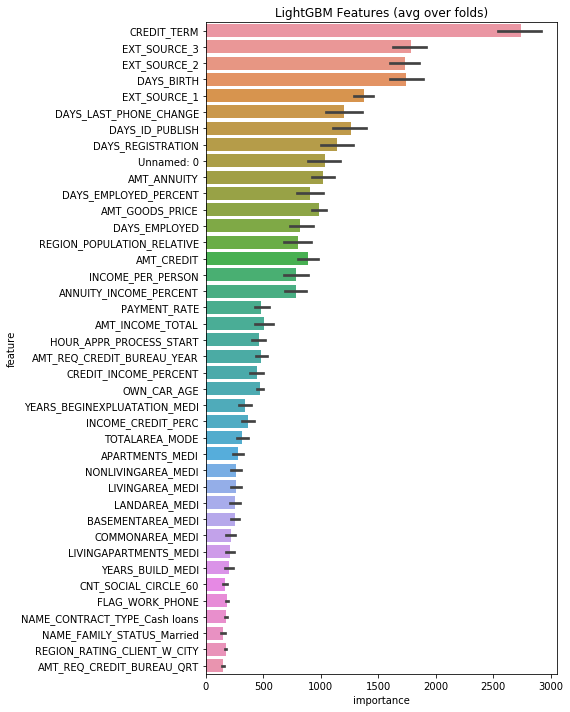

In [13]:
  # Display/plot feature importance
  def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances01.png')
    plt.show()

  display_importances(feature_importance_df)
  # return feature_importance_df

Average precision-recall score: 0.25


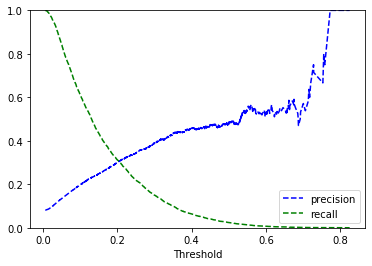

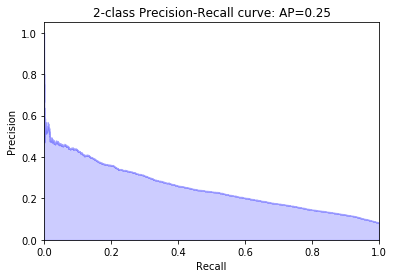

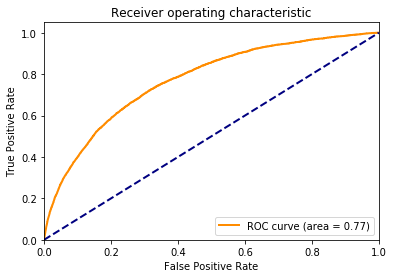

In [15]:
  test_df_submission = test_df.copy()
  test_df_submission['ORIG_TARGET'] = test_df_submission['TARGET']
  test_df_submission['TARGET'] = y_preds
  test_df_submission['SUB_PREDICTION'] = 1
  test_df_submission['SUB_PREDICTION'] = sub_preds
  test_df_submission[['SK_ID_CURR', 'ORIG_TARGET', 'TARGET', 'SUB_PREDICTION']].to_csv('submission_kernel03.csv', index= False)

  from sklearn.metrics import average_precision_score
  from sklearn.metrics import precision_recall_curve
  from sklearn.metrics import accuracy_score
  import matplotlib.pyplot as plt
  from inspect import signature

  average_precision = average_precision_score(test_df_submission['ORIG_TARGET'], sub_preds)
  print ('Average precision-recall score: {0:0.2f}'.format(
        average_precision))

  # Plot Precision Recall vs Threshold curve
  prec, rec, tre = precision_recall_curve(test_df_submission['ORIG_TARGET'], sub_preds)
  def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0,1])

  plot_prec_recall_vs_tresh(prec, rec, tre)
  plt.show()

  # Plot Precision Recall curve
  step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
  plt.step(rec, prec, color='b', alpha=0.2,
          where='post')
  plt.fill_between(rec, prec, alpha=0.2, color='b', **step_kwargs)

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
  
  # Plot ROC curve
  from sklearn.metrics import roc_curve, auc
  fpr, tpr, _ = roc_curve(test_df_submission['ORIG_TARGET'], sub_preds)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

In [22]:
type(y_preds)

numpy.ndarray

In [24]:
# Print accuracy score
  y_preds_new = np.array(y_preds, dtype=np.int64)
  y_true = pd.Series(test_df_submission['ORIG_TARGET']).values
  acc_score = accuracy_score(y_true, y_preds_new)
  print ('Accuracy score: {0:0.2f}'.format(acc_score))

  from sklearn.metrics import confusion_matrix
  print(confusion_matrix(y_true, y_preds))

Accuracy score: 0.92
[[56139    41    23    12    17     9    10    20    14    23    61]
 [ 4739    44    26     9    10    12     8    11    12    17    67]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0]]
